## === Research Zone ===

### 1. Import Libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import networkx as nx
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from ipycytoscape import CytoscapeWidget
from cdlib import algorithms, viz, readwrite, evaluation
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'karateclub', 'graph_tool', 'infomap'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'karateclub', 'ASLPAw'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


### 2. Load Adjacency Matrix from Wang, Jiang, and Lin Method

In [2]:
df_wang = pd.read_excel('./../data/adjmatrix-Wang.xlsx')
df_jiang = pd.read_excel('./../data/adjmatrix-Jiang.xlsx')
df_lin = pd.read_excel('./../data/adjmatrix-Lin.xlsx')

### 3. Drop Row and Column with NAN Values

In [3]:
df_wang = df_wang.dropna(axis=0, thresh=3)
df_wang = df_wang.dropna(axis=1, thresh=3)
print(len(df_wang))

df_jiang = df_jiang.dropna(axis=0, thresh=3)
df_jiang = df_jiang.dropna(axis=1, thresh=3)
print(len(df_jiang))

df_lin = df_lin.dropna(axis=0, thresh=3)
df_lin = df_lin.dropna(axis=1, thresh=3)
print(len(df_lin))

845
845
845


### 4. Plot Wang, Jiang, and Lin Graphs' Edges Count

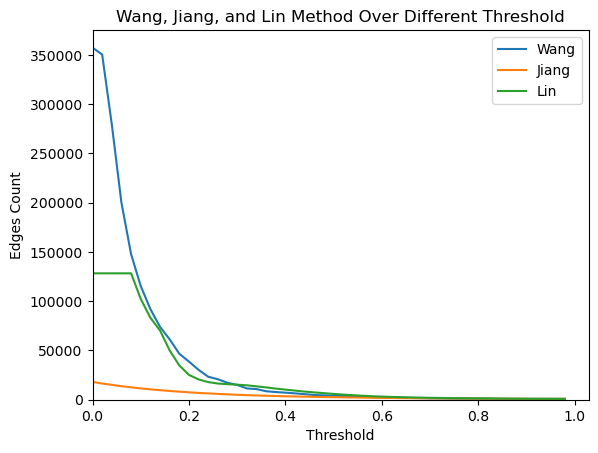

In [4]:
threshold_list = []
edges_list_wang = []
edges_list_jiang = []
edges_list_lin = []

for i in np.arange(0, 1, 0.02):
    k = copy.deepcopy(df_wang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    threshold_list.append(i)
    edges_list_wang.append(edges)
    
    k = copy.deepcopy(df_jiang)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_jiang.append(edges)
    
    k = copy.deepcopy(df_lin)
    k[k < i] = 0
    graph = nx.from_numpy_matrix(k.values)
    graph = nx.relabel_nodes(graph, dict(enumerate(k.columns)))
    edges = graph.number_of_edges()
    edges_list_lin.append(edges)

plt.title("Wang, Jiang, and Lin Method Over Different Threshold")
plt.plot(threshold_list, edges_list_wang)
plt.plot(threshold_list, edges_list_jiang)
plt.plot(threshold_list, edges_list_lin)
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Threshold")
plt.ylabel("Edges Count")
plt.legend(['Wang', 'Jiang', 'Lin'])
plt.show()

### 5. Choose Wang Method with Threshold = 0.5, Make The Graph and See The Nodes Degree Distribution

Initial Node Count: 845
Initial Edge Count: 4000
Nodes that will be used as giant component: 323
Giant component node count: 323
Giant component edge count: 1401


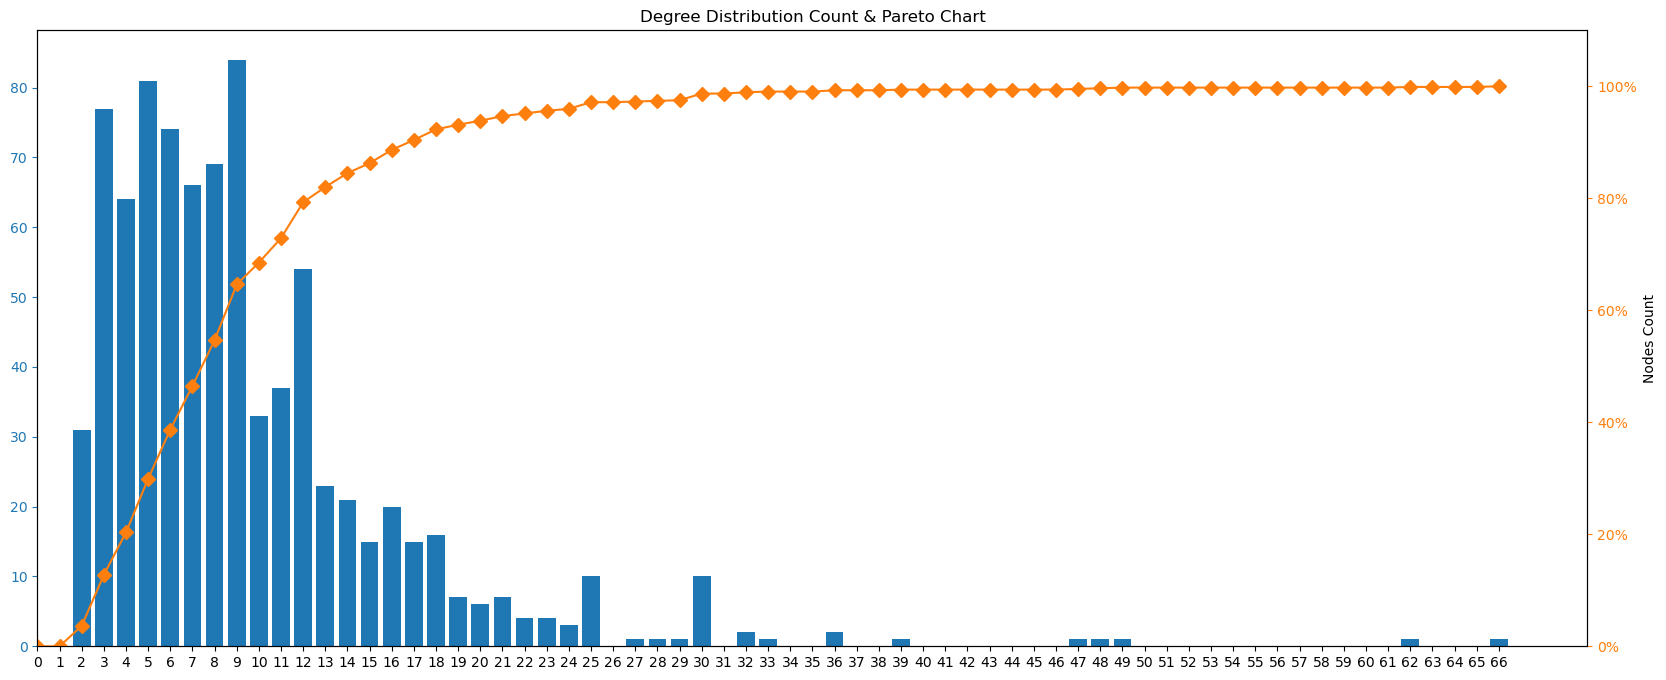

In [5]:
df_wang[df_wang < 0.5] = 0

graph = nx.from_numpy_matrix(df_wang.values)
graph = nx.relabel_nodes(graph, dict(enumerate(df_wang.columns)))

node_cnt = graph.number_of_nodes()
edges_cnt = graph.number_of_edges()

print("Initial Node Count: " + str(node_cnt))
print("Initial Edge Count: " + str(edges_cnt))

nx.write_edgelist(graph, "full_graph.edgelist", data=False)

nodes_of_largest_component  = max(nx.connected_components(graph), key = len)
print("Nodes that will be used as giant component: " + str(len(nodes_of_largest_component)))
g = graph.subgraph(nodes_of_largest_component)
nx.write_edgelist(g, "giant_subgraph.edgelist", data=False)
overall_density = nx.density(g)

node_cnt_sub = g.number_of_nodes()
edges_cnt_sub = g.number_of_edges()

print("Giant component node count: " + str(node_cnt_sub))
print("Giant component edge count: " + str(edges_cnt_sub))

degree = graph.degree()

degree_dic = {}
for nodes, deg in degree:
    if deg not in degree_dic:
        degree_dic[deg] = 1
    else:
        degree_dic[deg] += 1

for i in range(0, 67):
    if i not in degree_dic:
        degree_dic[i] = 0
k = sorted(degree_dic.items())
    
data = pd.DataFrame(k, columns =['Degree', 'Count'])
data["cumpercentage"] = data["Count"].cumsum()/data["Count"].sum()*100

fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(data["Degree"], data["Count"], color="C0")
ax2 = ax.twinx()
ax2.plot(data["Degree"], data["cumpercentage"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
plt.xlim(0, 70)
plt.ylim(0, 110)
plt.xlabel("Degree")
plt.ylabel("Nodes Count")
plt.title("Degree Distribution Count & Pareto Chart")
plt.xticks(range(0, 67))
plt.show()

### 6. Plot The Largest Component Beside The Rest of The Graph w/ Cytoscape Widget

In [6]:
cyto = CytoscapeWidget()

for node in g.nodes(data=True):
    node[1]["classes"] = 'classRey'
    
for s, t, data in g.edges(data=True):
    g[s][t]['classes'] = 'classRey'
    
cyto.graph.add_graph_from_networkx(graph)
cyto.set_style(
    [
        {
             'selector': 'node.classRey',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge.classRey',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto)

### 7. Plot The Larget Component On Its Own w/ Cytoscape Widget

In [7]:
cyto_largest = CytoscapeWidget()
cyto_largest.graph.add_graph_from_networkx(g)
cyto_largest.set_style(
    [
        {
             'selector': 'node',
             'style': {
                 'background-color': 'green'
             }
        },
        {
             'selector': 'edge',
             'style': {
                 'line-color': '#A0FFA0'
             }
        }
    ]
)
display(cyto_largest)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 8. Initialize The Position of Graph and Get The Communities with All Algorithms

In [8]:
random_pos = nx.random_layout(g, seed=42)

coms_bel = algorithms.belief(g)
coms_gn = algorithms.girvan_newman(g, level=5)
coms_sg = algorithms.spinglass(g)

readwrite.write_community_csv(coms_sg, "spinglass-communities.csv", ",")
readwrite.write_community_csv(coms_gn, "girvannewman-communities.csv", ",")
readwrite.write_community_csv(coms_bel, "belief-communities.csv", ",")

### 9.a.1. Using Belief as Community Algorithm - Network Cluster

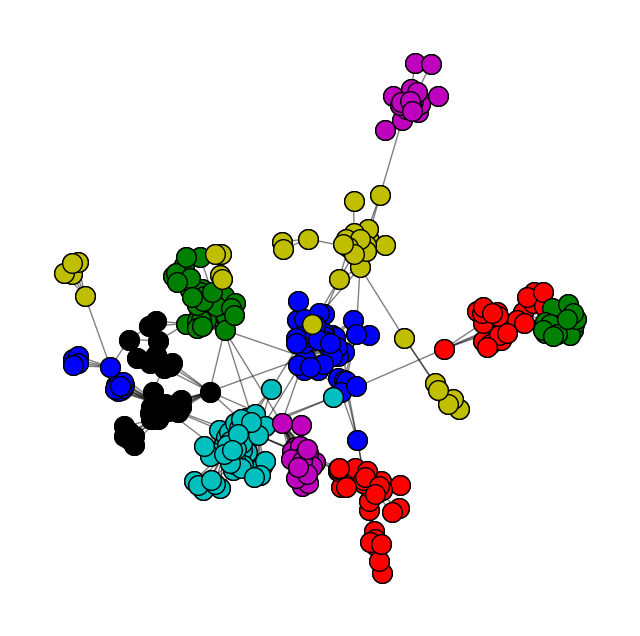

In [9]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_bel, pos)

### 9.a.2. Plot the Community Graph

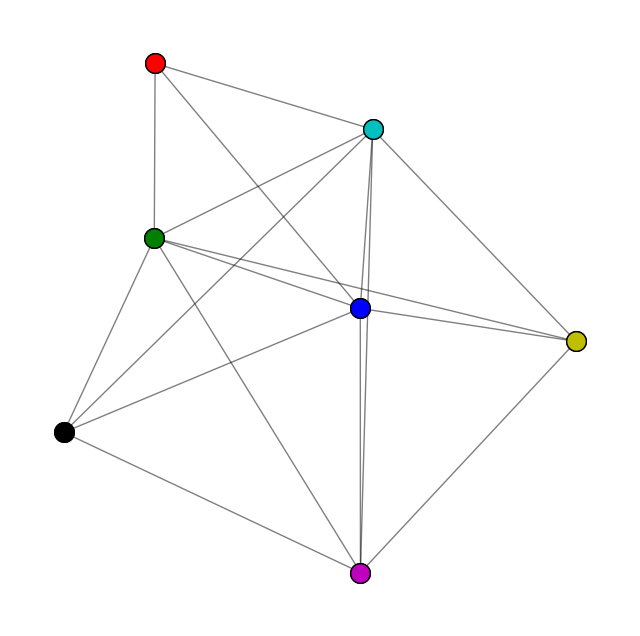

In [10]:
viz.plot_community_graph(g, coms_bel)

### 9.a.3. Evaluate the Modularity

In [11]:
algorithm = "belief"
m1 = evaluation.erdos_renyi_modularity(g, coms_bel)
m2 = evaluation.link_modularity(g, coms_bel)
m3 = evaluation.modularity_density(g, coms_bel)
m4 = evaluation.newman_girvan_modularity(g, coms_bel)
m5 = evaluation.z_modularity(g, coms_bel)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

eval_table = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

0.8242413621253363
0.10696983781767433
56.58044529944213
0.8244413594197606
2.266016516443662


### 9.b.1. Using Girvan Newman as Community Algorithm - Network Cluster

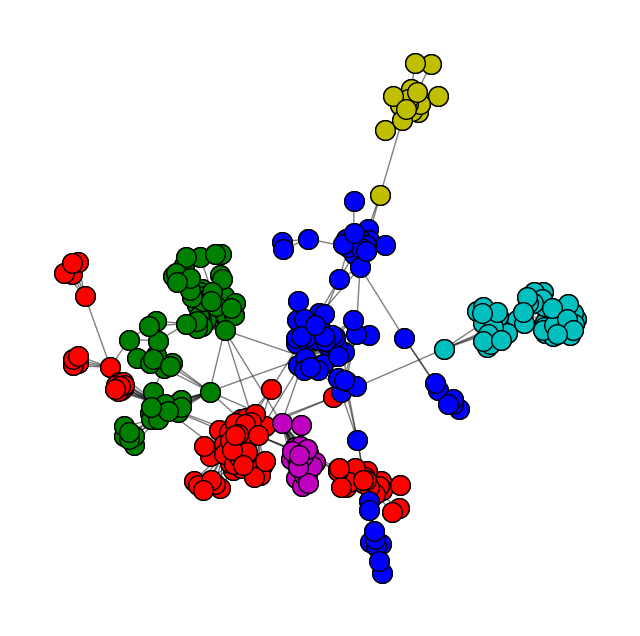

In [12]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_gn, pos)

### 9.b.2. Plot the Community Graph

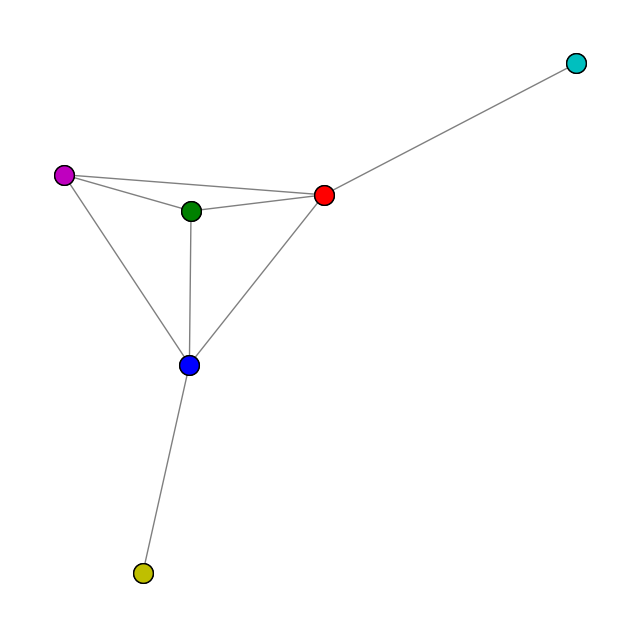

In [13]:
viz.plot_community_graph(g, coms_gn)

### 9.b.3. Evaluate the Modularity

In [14]:
algorithm = "girvan newman"
m1 = evaluation.erdos_renyi_modularity(g, coms_gn)
m2 = evaluation.link_modularity(g, coms_gn)
m3 = evaluation.modularity_density(g, coms_gn)
m4 = evaluation.newman_girvan_modularity(g, coms_gn)
m5 = evaluation.z_modularity(g, coms_gn)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.7848266674012643
0.10986069551772568
54.136951170455006
0.7911830408731146
1.9696240625506558


### 9.c.1. Using Spinglass as Community Algorithm - Network Cluster

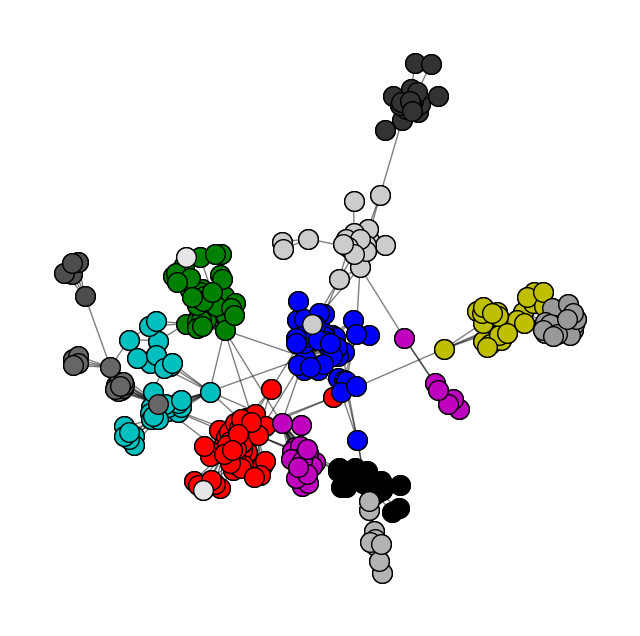

In [15]:
pos = nx.spring_layout(g, pos = random_pos)
viz.plot_network_clusters(g, coms_sg, pos)

### 9.c.2. Plot the Community Graph

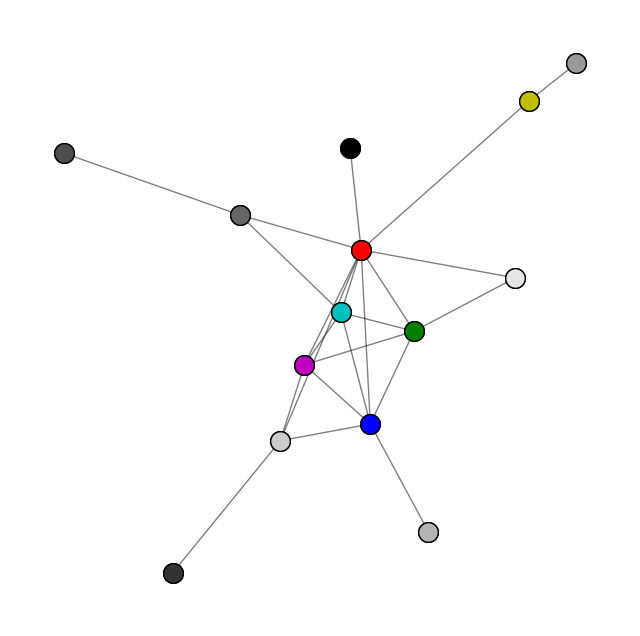

In [16]:
viz.plot_community_graph(g, coms_sg)

### 9.c.3. Evaluate the Modularity

In [17]:
algorithm = "spinglass"
m1 = evaluation.erdos_renyi_modularity(g, coms_sg)
m2 = evaluation.link_modularity(g, coms_sg)
m3 = evaluation.modularity_density(g, coms_sg)
m4 = evaluation.newman_girvan_modularity(g, coms_sg)
m5 = evaluation.z_modularity(g, coms_sg)

print(m1.score)
print(m2.score)
print(m3.score)
print(m4.score)
print(m5.score)

temp = pd.DataFrame({"Algorithm":algorithm,
                         "Erdos Renyi Mod.": [m1.score], 
                         "Link Mod.": [m2.score],
                         "Mod. Density": [m3.score],
                         "Newman Girvan Mod.": [m4.score],
                         "Z Mod.": [m5.score]})

eval_table = eval_table.append(temp)

0.8790051548527722
0.10686658557974803
103.47546498273694
0.8801880208043973
2.951224184088934


### 10. Get the Result of Each Algorithm Modularity Score

In [18]:
eval_table

,Algorithm,Erdos Renyi Mod.,Link Mod.,Mod. Density,Newman Girvan Mod.,Z Mod.
0,belief,0.824241,0.106970,56.580445,0.824441,2.266017
0,girvan newman,0.784827,0.109861,54.136951,0.791183,1.969624
0,spinglass,0.879005,0.106867,103.475465,0.880188,2.951224


### 11. Standardize data, PCA them

In [19]:
df = eval_table.iloc[:, 1:6]

scaler = MinMaxScaler()
df = scaler.fit_transform(df)
pca = PCA(n_components=1, random_state=0, svd_solver='randomized')
model = pca.fit(df)
df = model.transform(df)
print(df)

[[-0.13220234]
 [-1.05124059]
 [ 1.18344293]]


### 12. Get the Eigenvector

In [20]:
print(pca.components_)

[[ 0.44711081 -0.41844978  0.4664443   0.44946039  0.45321825]]


### 13. Get the Eigenvalue

In [21]:
print(pca.explained_variance_)

[1.26156071]


### 14. Get the Algorithms Ranking

In [22]:
eval_table_after_pca = pd.DataFrame(df)
eval_table_after_pca = eval_table.iloc[:, 0].reset_index().join(eval_table_after_pca).drop(columns=['index'])
eval_table_after_pca.sort_values(by=0, ascending=False)

,Algorithm,0
2,spinglass,1.183443
0,belief,-0.132202
1,girvan newman,-1.051241


### 15.a. Centrality, Size, Edges Count, and Average Degree for Belief Algorithm

In [23]:
bel_com = pd.read_csv('belief-communities.csv', header=None)
bel_size = []
bel_edges = []
bel_sd = []

for i in range(len(bel_com)):
    doid_list = []
    doid_sign = []
    for j in bel_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    bel_size.append(("Belief", com_graph.number_of_nodes()))
    bel_edges.append(("Belief", com_graph.number_of_edges()))
    bel_sd.append(("Belief", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.8466']

2
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.0050736']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

5
['DOID.2723']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.417']
['DOID.417']
['DOID.417']
['DOID.417']

7
['DOID.17']
['DOID.0080001']
['DOID.17']
['DOID.0080001']



### 15.b. Centrality, Size, Edges Count, and Average Degree for Girvan-Newman Algorithm

In [24]:
gn_com = pd.read_csv('girvannewman-communities.csv', header=None)
gn_size = []
gn_edges = []
gn_sd = []

for i in range(len(gn_com)):
    doid_list = []
    doid_sign = []
    for j in gn_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    gn_size.append(("Girvan Newman", com_graph.number_of_nodes()))
    gn_edges.append(("Girvan Newman", com_graph.number_of_edges()))
    gn_sd.append(("Girvan Newman", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.409']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.150']
['DOID.150']
['DOID.150']
['DOID.0060037']

5
['DOID.850', 'DOID.0050161']
['DOID.850', 'DOID.0050161']
['DOID.850', 'DOID.0050161']
['DOID.850', 'DOID.0050161']

6
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']



### 15.c. Centrality, Size, Edges Count, and Average Degree for Spinglass Algorithm

In [25]:
sg_com = pd.read_csv('spinglass-communities.csv', header=None)
sg_size = []
sg_edges = []
sg_sd = []

for i in range(len(sg_com)):
    doid_list = []
    doid_sign = []
    for j in sg_com.iloc[i]:
        if str(j) != 'nan':
            doid_list.append(j)
    k = copy.deepcopy(df_wang)
    doid_col_nums = []
    for doid in doid_list:
        doid_col_nums.append(k.columns.get_loc(doid))
    community_adj_mat = k[doid_list].iloc[doid_col_nums]
    com_graph = nx.from_numpy_matrix(community_adj_mat.values)
    com_graph = nx.relabel_nodes(com_graph, dict(enumerate(community_adj_mat.columns)))
    
    sg_size.append(("Spinglass", com_graph.number_of_nodes()))
    sg_edges.append(("Spinglass", com_graph.number_of_edges()))
    sg_sd.append(("Spinglass", nx.density(com_graph)/overall_density))
    
    bc = nx.betweenness_centrality(com_graph)
    dc = nx.degree_centrality(com_graph)
    cc = nx.closeness_centrality(com_graph)
    ev = nx.eigenvector_centrality(com_graph, 1000)
    
    print(i+1)
    max_keys_bc = [key for key, value in bc.items() if value == max(bc.values())]
    print(max_keys_bc)
    max_keys_dc = [key for key, value in dc.items() if value == max(dc.values())]
    print(max_keys_dc)
    max_keys_cc = [key for key, value in cc.items() if value == max(cc.values())]
    print(max_keys_cc)
    max_keys_ev = [key for key, value in ev.items() if value == max(ev.values())]
    print(max_keys_ev)
    print()

1
['DOID.863']
['DOID.863']
['DOID.863']
['DOID.863']

2
['DOID.77']
['DOID.77']
['DOID.77']
['DOID.77']

3
['DOID.1287']
['DOID.1287']
['DOID.1287']
['DOID.1287']

4
['DOID.17']
['DOID.0080001']
['DOID.17']
['DOID.0080001']

5
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']
['DOID.0050161', 'DOID.850']

6
['DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561', 'DOID.150']
['DOID.1561']

7
['DOID.8466']
['DOID.8466']
['DOID.8466', 'DOID.0060260', 'DOID.790', 'DOID.9335']
['DOID.8466']

8
['DOID.0060056']
['DOID.417']
['DOID.417', 'DOID.0060056']
['DOID.417']

9
['DOID.2723']
['DOID.2723']
['DOID.2723']
['DOID.2723']

10
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']
['DOID.0060037']

11
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']
['DOID.0050736']

12
['DOID.557']
['DOID.557']
['DOID.557']
['DOID.557']

13
['DOID.630']
['DOID.630']
['DOID.630']
['DOID.630']

14
['DOID.0050754', 'DOID.3575']
['DOID.0050754', 'DOID.3575']
['DOID.0050754', 'DO

### 16. Fitness Function for Algorithms and Top 3 Fitness Function

In [26]:
algorithm_list = []
ae_list = []
aid_list = []
at_list = []
c_list = []
cr_list = []
ei_list = []
ex_list = []
fomd_list = []
ied_list = []
nc_list = []
modf_list = []
aodf_list = []
fodf_list = []
sd_list = []
sz_list = []
tpr_list = []

In [27]:
ae = evaluation.avg_embeddedness(g, coms_bel)
aid = evaluation.average_internal_degree(g, coms_bel)
at = evaluation.avg_transitivity(g, coms_bel)
c = evaluation.conductance(g, coms_bel)
cr = evaluation.cut_ratio(g, coms_bel)
ei = evaluation.edges_inside(g, coms_bel)
ex = evaluation.expansion(g, coms_bel)
fomd = evaluation.fraction_over_median_degree(g, coms_bel)
ied = evaluation.internal_edge_density(g, coms_bel)
nc = evaluation.normalized_cut(g, coms_bel)
modf = evaluation.max_odf(g, coms_bel)
aodf = evaluation.avg_odf(g, coms_bel)
fodf = evaluation.flake_odf(g, coms_bel)
sd = evaluation.scaled_density(g, coms_bel)
sz = evaluation.size(g, coms_bel)
tpr = evaluation.triangle_participation_ratio(g, coms_bel)

print("Belief")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Belief")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Belief
0.97840154747088
8.336925339369298
0.7423274090483611
0.030760510262013076
0.0009221184167465916
194.14285714285714
0.2540045823061365
0.43429806558666556
0.19079878123030394
0.03575139463796476
5.0
0.2540045823061365
0.0
7.08216204162705
46.142857142857146
0.9007252893602539


In [28]:
ae = evaluation.avg_embeddedness(g, coms_gn)
aid = evaluation.average_internal_degree(g, coms_gn)
at = evaluation.avg_transitivity(g, coms_gn)
c = evaluation.conductance(g, coms_gn)
cr = evaluation.cut_ratio(g, coms_gn)
ei = evaluation.edges_inside(g, coms_gn)
ex = evaluation.expansion(g, coms_gn)
fomd = evaluation.fraction_over_median_degree(g, coms_gn)
ied = evaluation.internal_edge_density(g, coms_gn)
nc = evaluation.normalized_cut(g, coms_gn)
modf = evaluation.max_odf(g, coms_gn)
aodf = evaluation.avg_odf(g, coms_gn)
fodf = evaluation.flake_odf(g, coms_gn)
sd = evaluation.scaled_density(g, coms_gn)
sz = evaluation.size(g, coms_gn)
tpr = evaluation.triangle_participation_ratio(g, coms_gn)

print("Girvan-Newman")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Girvan-Newman")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Girvan-Newman
0.9917380907751573
9.118098522676528
0.7223765604420117
0.010177672258942517
0.00035145947273181635
231.16666666666666
0.09527332760069333
0.4507960742487596
0.26306165549857574
0.012257236023101687
3.0
0.09527332760069333
0.0
9.764450585933217
53.833333333333336
0.892229246551497


In [29]:
ae = evaluation.avg_embeddedness(g, coms_sg)
aid = evaluation.average_internal_degree(g, coms_sg)
at = evaluation.avg_transitivity(g, coms_sg)
c = evaluation.conductance(g, coms_sg)
cr = evaluation.cut_ratio(g, coms_sg)
ei = evaluation.edges_inside(g, coms_sg)
ex = evaluation.expansion(g, coms_sg)
fomd = evaluation.fraction_over_median_degree(g, coms_sg)
ied = evaluation.internal_edge_density(g, coms_sg)
nc = evaluation.normalized_cut(g, coms_sg)
modf = evaluation.max_odf(g, coms_sg)
aodf = evaluation.avg_odf(g, coms_sg)
fodf = evaluation.flake_odf(g, coms_sg)
sd = evaluation.scaled_density(g, coms_sg)
sz = evaluation.size(g, coms_sg)
tpr = evaluation.triangle_participation_ratio(g, coms_sg)

print("Spinglass")
print(ae.score)
print(aid.score)
print(at.score)
print(c.score)
print(cr.score)
print(ei.score)
print(ex.score)
print(fomd.score)
print(ied.score)
print(nc.score)
print(modf.score)
print(aodf.score)
print(fodf.score)
print(sd.score)
print(sz.score)
print(tpr.score)

algorithm_list.append("Spinglass")
ae_list.append(ae.score)
aid_list.append(aid.score)
at_list.append(at.score)
c_list.append(c.score)
cr_list.append(cr.score)
ei_list.append(ei.score)
ex_list.append(ex.score)
fomd_list.append(fomd.score)
ied_list.append(ied.score)
nc_list.append(nc.score)
modf_list.append(modf.score)
aodf_list.append(aodf.score)
fodf_list.append(fodf.score)
sd_list.append(sd.score)
sz_list.append(sz.score)
tpr_list.append(tpr.score)

Spinglass
0.9549012806584483
7.707656277193858
0.6792760071335163
0.05461473297195422
0.0010448464221442066
97.0
0.31655163556979066
0.35893178739794024
0.5644510126167163
0.057011505724061766
3.2142857142857144
0.31655163556979066
0.0
20.951567458320557
23.071428571428573
0.8199561538022924


In [30]:
list_fit = np.array([ae_list, aid_list, at_list, c_list, cr_list, ei_list, ex_list, fomd_list, ied_list, nc_list, modf_list, aodf_list, fodf_list, sd_list, sz_list, tpr_list])
fitness_df = pd.DataFrame(list_fit, index = [
    "Average Embeddedness",
    "Average Internal Degree",
    "Average Transitivity",
    "Conductance",
    "Cut Ratio",
    "Edges Inside",
    "Expansion",
    "Fraction Over Median Degree",
    "Internal Edge Density",
    "Normalized Cut",
    "Max ODF",
    "Average ODF",
    "Flake ODF",
    "Scaled Density",
    "Size",
    "Triangle Participation Ratio"
], columns=algorithm_list)

print(fitness_df)

scaler = MinMaxScaler()
fitness_df_pca = scaler.fit_transform(fitness_df)
pca = PCA(n_components=1, random_state=0, svd_solver='randomized')
model = pca.fit(fitness_df_pca)
fitness_df_pca = model.transform(fitness_df_pca)

                                  Belief  Girvan-Newman  Spinglass
Average Embeddedness            0.978402       0.991738   0.954901
Average Internal Degree         8.336925       9.118099   7.707656
Average Transitivity            0.742327       0.722377   0.679276
Conductance                     0.030761       0.010178   0.054615
Cut Ratio                       0.000922       0.000351   0.001045
Edges Inside                  194.142857     231.166667  97.000000
Expansion                       0.254005       0.095273   0.316552
Fraction Over Median Degree     0.434298       0.450796   0.358932
Internal Edge Density           0.190799       0.263062   0.564451
Normalized Cut                  0.035751       0.012257   0.057012
Max ODF                         5.000000       3.000000   3.214286
Average ODF                     0.254005       0.095273   0.316552
Flake ODF                       0.000000       0.000000   0.000000
Scaled Density                  7.082162       9.764451  20.95

### Get the Eigenvector

In [31]:
print(pca.components_)

[[0.57766888 0.57809498 0.5762854 ]]


### Get the Eigenvalue

In [32]:
print(pca.explained_variance_)

[0.1879502]


### Get the Top 3 Fitness Function

In [33]:
fit_after_pca = pd.DataFrame(fitness_df_pca, columns=['Value'])
fit_after_pca = pd.concat([pd.DataFrame([x for x in fitness_df.index], columns=['Fitness Function']), fit_after_pca], axis=1)
fit_after_pca.sort_values(by='Value', ascending=False)

,Fitness Function,Value
5,Edges Inside,1.576387
14,Size,0.253330
13,Scaled Density,0.014305
1,Average Internal Degree,-0.062261
10,Max ODF,-0.114186
0,Average Embeddedness,-0.144597
15,Triangle Participation Ratio,-0.145879
2,Average Transitivity,-0.147611
8,Internal Edge Density,-0.151083
7,Fraction Over Median Degree,-0.151110


### 17. Make the DataFrame for Size, Edges, and Average Node Degree

In [34]:
algo_size_sg = pd.DataFrame(sg_size, columns=["Algorithm", "Size"])
algo_size_gn = pd.DataFrame(gn_size, columns=["Algorithm", "Size"])
algo_size_bel = pd.DataFrame(bel_size, columns=["Algorithm", "Size"])
algo_size_2 = pd.concat([algo_size_sg, algo_size_gn, algo_size_bel])
algo_size_2.to_excel("13-10-2023_AlgoSize.xlsx")
algo_size_2

,Algorithm,Size
0,Spinglass,48
1,Spinglass,40
2,Spinglass,36
3,Spinglass,31
4,Spinglass,29
5,Spinglass,27
6,Spinglass,22
7,Spinglass,21
8,Spinglass,20
9,Spinglass,18


In [35]:
algo_edge_sg = pd.DataFrame(sg_edges, columns=["Algorithm", "Edge"])
algo_edge_gn = pd.DataFrame(gn_edges, columns=["Algorithm", "Edge"])
algo_edge_bel = pd.DataFrame(bel_edges, columns=["Algorithm", "Edge"])
algo_edge_2 = pd.concat([algo_edge_sg, algo_edge_gn, algo_edge_bel])
algo_edge_2.to_excel("13-10-2023_AlgoEdge.xlsx")
algo_edge_2

,Algorithm,Edge
0,Spinglass,220
1,Spinglass,152
2,Spinglass,151
3,Spinglass,116
4,Spinglass,151
5,Spinglass,102
6,Spinglass,99
7,Spinglass,61
8,Spinglass,106
9,Spinglass,79


In [36]:
algo_sd_sg = pd.DataFrame(sg_sd, columns=["Algorithm", "SD"])
algo_sd_gn = pd.DataFrame(gn_sd, columns=["Algorithm", "SD"])
algo_sd_bel = pd.DataFrame(bel_sd, columns=["Algorithm", "SD"])
algo_sd_2 = pd.concat([algo_sd_sg, algo_sd_gn, algo_sd_bel])
algo_sd_2.to_excel("13-10-2023_ScaledDensity.xlsx")
algo_sd_2

,Algorithm,SD
0,Spinglass,7.239421
1,Spinglass,7.233346
2,Spinglass,8.896653
3,Spinglass,9.259666
4,Spinglass,13.805151
5,Spinglass,10.786569
6,Spinglass,15.907923
7,Spinglass,10.782037
8,Spinglass,20.708208
9,Spinglass,19.165755


### 18.a. Swarm Plot of Size Each Algorithm

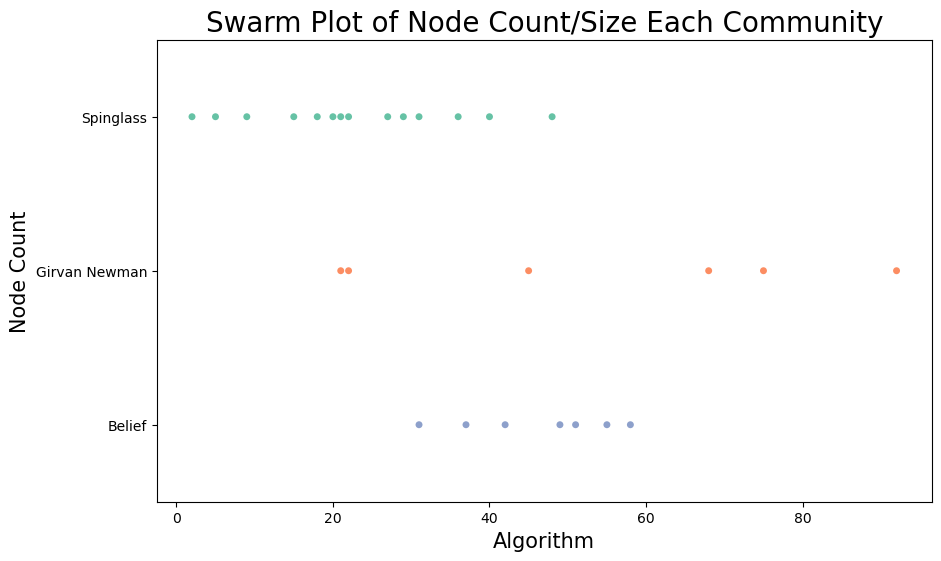

In [37]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Size', y='Algorithm', data=algo_size_2, palette='Set2')
plt.title('Swarm Plot of Node Count/Size Each Community', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Node Count', fontsize=15)
plt.show()

### 18.b. Swarm Plot of Edges Size Each Algorithm

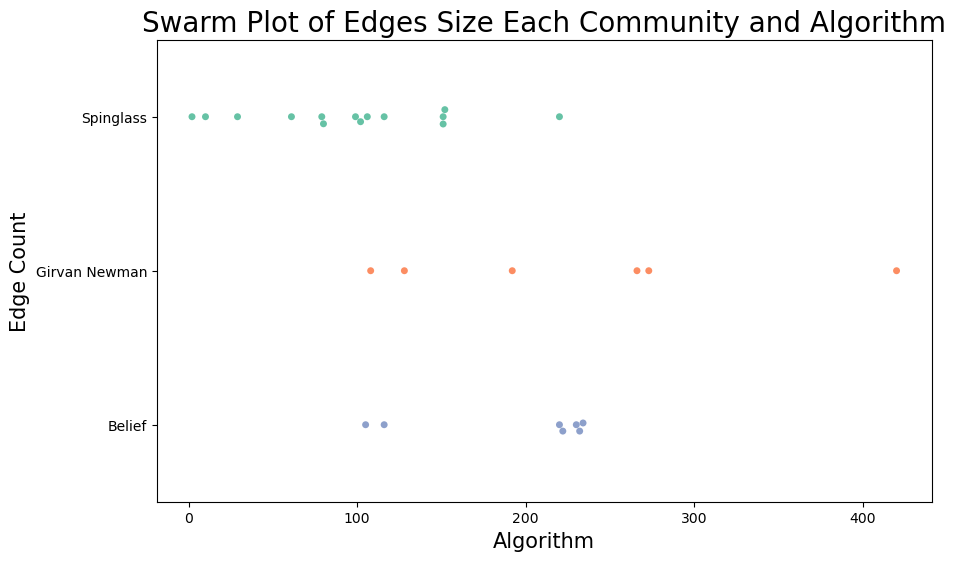

In [38]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='Edge', y='Algorithm', data=algo_edge_2, palette='Set2')
plt.title('Swarm Plot of Edges Size Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Edge Count', fontsize=15)
plt.show()

### 18.c. Swarm Plot of Scaled Density Each Algorithm

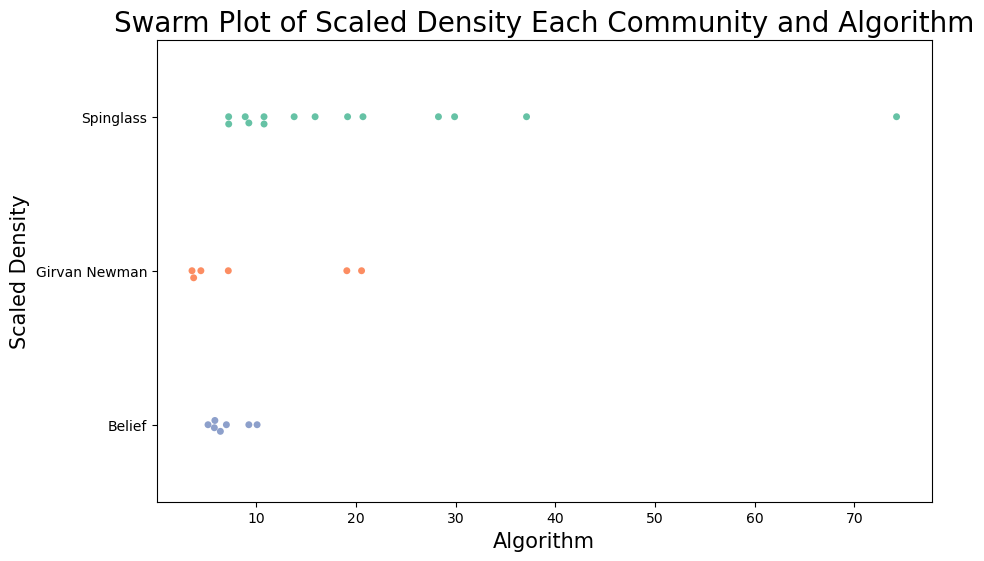

In [39]:
plt.figure(figsize=(10,6))
sns.swarmplot(x='SD', y='Algorithm', data=algo_sd_2, palette='Set2')
plt.title('Swarm Plot of Scaled Density Each Community and Algorithm', fontsize=20)
plt.xlabel('Algorithm', fontsize=15)
plt.ylabel('Scaled Density', fontsize=15)
plt.show()